## Imports

In [1]:
import pandas as pd

import requests, zipfile, io

import osmnx as ox
import geopandas as gpd
import pandas as pd

import folium
import os

# for routing table:
import osrm

In [2]:
# %load https://gist.github.com/TRomijn/d9d28ba7b7d5eeac1deea5a26dd326b2/raw/loaded_modules.py

'''
original author: kinverarity1

List loaded modules and packages, and show their version numbers
and/or Git repository's HEAD commit SHA.


Changes:
Minor changes to make compatible with Python 3
'''
# Standard library modules
import types
import os

# Third-party packages
import git      # GitPython


def module_path(mod):
    '''Returns path to the file that module *mod* comes from.
    If it doesn't come from a file, return None.'''
    if hasattr(mod, '__file__'):
        return os.path.abspath(os.path.dirname(mod.__file__))
    else:
        return None

    
def from_git_repo(mod):
    '''Does the module *mod* reside in a Git repository?'''
    path = module_path(mod)
    if path:
        try:
            repo = git.Repo(path)
        except:
            return False
        else:
            return True
    else:
        return False

    
def git_path_sha(mod, slice=slice(0, 8, 1)):
    '''Return SHA hash for the HEAD commit for the repository
    that the module *mod* resides in.'''
    repo = git.Repo(module_path(mod))
    return repo.git_dir, repo.head.commit.hexsha[:8]


def module_version(mod):
    '''Return version string for module *mod*, or nothing if
    it doesn't have a "version" or "__version__" attribute.'''
    version = []
    if hasattr(mod, '__dict__'):
        keys = []
        for key in mod.__dict__.keys():
            if key.lower() == 'version' or key.lower() == '__version__':
                v = mod.__dict__[key]
                if isinstance(v, str):
                    version.append(v)
        if keys:
            print (mod, keys)
    if version:
        return ', '.join(version)
    else:
        return ''

    
def find_loaded_modules(only_versioned_modules=True):
    '''Return list of loaded modules for which there is a version
    number or a Git repository commit SHA.
    
    Return a list of *(name, version, path_to_git_repo, git_head_sha)*,
    which has an HTML property for pretty display in IPython Notebooks.
        
    '''
    def list_of_lists_to_HTML(lists, header_row=None):
        '''Convert a list of a list of strings to a HTML table.'''
        s = '<table>'
        if header_row:
            s += '\n\t<tr>\n\t\t'
            s += ''.join(['<th>%s</th>' % item for item in header_row])
            s += '\n\t</tr>'
        for inner_list in lists:
            s += '\n\t<tr>\n\t\t'
            s += ''.join(['<td>%s</td>' % item for item in inner_list])
            s += '\n\t</tr>'
        s += '\n</table>'
        return s
    
    class LoadedModules(list):
        '''Very simple wrapper for a list of lists of strings, with an attribute
        for display in IPython Notebooks.'''
        def __init__(self, *args, **kwargs):
            list.__init__(self, *args, **kwargs)
            
        @property
        def HTML(self):
            from IPython.display import HTML
            return HTML(
                    list_of_lists_to_HTML(
                            self, header_row=['Name', 'Version', 'Path', 'SHA']))
                    
    objs = LoadedModules()
    for i, mod in enumerate(globals().values()):
        if isinstance(mod, types.ModuleType):
            if hasattr(mod, '__name__'):
                name = mod.__name__
            else:
                name = ''
            
            if from_git_repo(mod):
                path, sha = git_path_sha(mod)
            else:
                path = ''
                sha = ''
            
            version = module_version(mod)
            
            if only_versioned_modules:
                flag = version or (path and sha)
            else:
                flag = True
            
            if flag:
                objs.append([mod.__name__, version, path, sha])
    objs.sort(key=lambda r: r[0])
    return objs


    
    

In [3]:
find_loaded_modules().HTML

Name,Version,Path,SHA
folium,0.5.0,,
geopandas,0.3.0,,
git,2.1.9,,
json,2.0.9,,
osmnx,0.8.1,,
osrm,0.11.1,,
pandas,0.23.0,,
requests,2.18.4,,


# Data preparation

## Demand Points

In [6]:
def get_cities(countrycode, number_of_cities=None, dataset="cities5000"):
    """
    countrycode: string: ISO "ALPHA-2 Code"
    number_of_cities: integer: number of cities to return, if None: return all
    dataset: string: choose from: ["cities1000","cities5000","cities15000"]
        chooses dataset with all world cities that have minimum that amount of inhabitants.
        Obivously, the cities1000 dataset is larger and can take longer to download than the cities15000
    
    Data is downloaded from: http://download.geonames.org/export/dump/
    This Data is licensed under a Creative Commons Attribution 3.0 License
    """

    #     http://download.geonames.org/export/dump/

    #     "cities15000"

    r = requests.get(
        "http://download.geonames.org/export/dump/{}.zip".format(dataset))
    z = zipfile.ZipFile(io.BytesIO(r.content))

    #     data_directory = "../Facility Location Model/Raw_Data"
    #     z.extractall(path=data_directory)

    columnnames = [
        "geonameid", "name", "asciiname", "alternatenames", "latitude",
        "longitude", "feature class", "feature code", "country code", "cc2",
        "admin1 code", "admin2 code", "admin3 code", "admin4 code",
        "population", "elevation", "dem", "timezone", "modification date"
    ]

    #     NP = pd.read_csv(data_directory+"/NP.txt", sep="\t", header=None)
    cities = pd.read_csv(
        z.open('{}.txt'.format(dataset)), sep="\t", names=columnnames)

    inCountry = cities[cities['country code'] == countrycode]

    inCountry = inCountry.dropna(subset=['population'])

    inCountrySorted = inCountry.sort_values(
        by='population', ascending=False).reset_index(drop=True)

    return inCountrySorted.iloc[0:number_of_cities]

In [7]:
cities = get_cities("NP", 30)

C:\Users\timro\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2903: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [8]:
DPs = cities[['name','population','latitude','longitude']]

In [9]:
DPs.tail()

,name,population,latitude,longitude
25,Birendranagar,31381,28.60194,81.63389
26,Panauti̇̄,27602,27.58453,85.51484
27,Gaur,27325,26.76448,85.27841
28,Siraha,24657,26.65422,86.20795
29,Tānsen,23693,27.86731,83.54670


### Add remote valleys

These remote valleys are not necessarily actually remote valleys. The 5 smallest cities are selected from the database, then  those are called "remote valleys"

For those smallest cities, there is no population information available. Therefore, they their population value is set on 1.000. Compared to the smallest normal city: it has a population of 23.693

In [10]:
all_cities = get_cities("NP", dataset="cities1000")

C:\Users\timro\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2903: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [11]:
# Cities are sorted on population
valleys = all_cities.tail(5)

In [12]:
valleys['population'] = 1000

C:\Users\timro\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [13]:
DPs = DPs.append(valleys[['name','population','latitude','longitude']])

In [14]:
DPs.tail(6)

,name,population,latitude,longitude
29,Tānsen,23693,27.86731,83.54670
60,Bardiyā,1000,28.30058,81.35360
61,Rāmechhāp,1000,27.32560,86.08768
62,Salyān,1000,28.37858,82.17030
63,Bhaktapur,1000,27.67298,85.43005
64,Achhām,1000,29.05000,81.30000


## Facility Locations


Select specific places of interest as optional FLs

In [15]:
# # if place has multiple parts, select mainland
# gdf = ox.gdf_from_place('The Netherlands')
# geom = gdf['geometry'].iloc[0]
# geom_proj, crs = ox.project_geometry(geom)
# area = geom_proj.envelope.area / 1e6

# print('{:,.0f} sq km'.format(area))
# # gdf.plot()

# mainland = max(geom, key=lambda x: x.area)
# # or manually check shapes and select
# mainland = geom[2]
# pois = ox.pois_from_polygon(mainland, amenities=['hospital'])

In [16]:
POIs = ox.pois_from_place(place='Nepal', amenities=['hospital'])

In [17]:
POIs.amenity.value_counts()

hospital         804
pharmacy           2
health_post        1
parking_space      1
atm                1
Name: amenity, dtype: int64

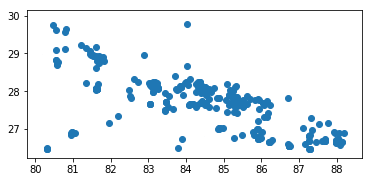

In [18]:
POIs.plot()

In [19]:
# place = "Nepal"
# POIs = ox.pois_from_place(place=place)

In [20]:
hospitals = POIs [POIs.amenity =='hospital']

In [21]:
hospitals = hospitals[hospitals.element_type == 'node']

In [22]:
hospital_coordinates = pd.DataFrame([point.coords[0] for point in pd.Series(hospitals.geometry)],columns=["longitude","latitude"])

In [23]:
hospital_coordinates.tail()

,longitude,latitude
430,87.984007,26.643996
431,84.879983,27.806481
432,85.245550,27.987440
433,85.296484,28.110444
434,85.321544,27.668370


In [45]:
# hospital_coordinates = hospital_coordinates.sample(30).reset_index(drop=True)

In [ ]:
# 
# hospital_coordinates.to_csv("Some folder / filename.csv", index=False)

In [24]:
hospital_coordinates = pd.read_csv("Data/Nepal_Prepared_Data/sample_hospitals.csv")

In [25]:
FLs = hospital_coordinates
FLs['Name'] = ['FLO{}'.format(i) for i in range(FLs.shape[0])]

FLs.columns = ["Lon","Lat", 'Name']
FLs = FLs[['Name', 'Lat', 'Lon']]

FLs.tail()

,Name,Lat,Lon
15,FLO15,27.994658,84.628128
16,FLO16,27.674426,85.403768
17,FLO17,27.711016,85.314744
18,FLO18,28.185470,83.178350
19,FLO19,28.753672,81.688045


## Supply points

In [26]:
url="http://ourairports.com/data/airports.csv"
s=requests.get(url).content
airports=pd.read_csv(io.StringIO(s.decode('utf-8')))

In [27]:
airports.columns

Index(['id', 'ident', 'type', 'name', 'latitude_deg', 'longitude_deg',
       'elevation_ft', 'continent', 'iso_country', 'iso_region',
       'municipality', 'scheduled_service', 'gps_code', 'iata_code',
       'local_code', 'home_link', 'wikipedia_link', 'keywords'],
      dtype='object')

In [28]:
# Select all airports in country
airports = airports[airports.iso_country == "NP"]

In [29]:
# Select airports that are available in country
int_airports = airports[airports.name == "Tribhuvan International Airport"]

In [30]:
SPs = int_airports[["name", "latitude_deg", "longitude_deg"]]

In [31]:
SPs

,name,latitude_deg,longitude_deg
50156,Tribhuvan International Airport,27.6966,85.3591


## Visualisation of nodes

In [32]:
FLs.tail(2)

,Name,Lat,Lon
18,FLO18,28.185470,83.178350
19,FLO19,28.753672,81.688045


In [33]:
map1 = folium.Map(
    location=[28.3, 84.12], zoom_start=6, tiles='cartodbpositron')

DPs.apply(lambda row: folium.CircleMarker(
    location=[row['latitude'], row['longitude']],
    radius=1, color="red", popup=row['name'] ).add_to(map1), axis=1)

SPs.apply(lambda row: folium.CircleMarker(
    location=[row['latitude_deg'], row['longitude_deg']],
    radius=3, color="blue").add_to(map1), axis=1)

FLs.apply(lambda row: folium.CircleMarker(
    location=[row['Lat'], row['Lon']],
    radius=3, color="green", popup=row['Name']).add_to(map1), axis=1)


map1

## Routes

In [34]:
node_names = ["SP{}".format(i) for i, ind in enumerate(SPs.index)] + [
    "FL{}".format(i) for i, ind in enumerate(FLs.index)
] + ["DP{}".format(i) for i, ind in enumerate(DPs.index)]

node_lats = SPs['latitude_deg'].append(FLs['Lat']).append(
    DPs['latitude']).reset_index(drop=True)

node_lons = SPs['longitude_deg'].append(FLs['Lon']).append(
    DPs['longitude']).reset_index(drop=True)

In [35]:
# for some reason the coordinates are incorrectly passed
# by this OSRM package
print("""
Hopefully at future updates of the osrm package, the
lat/lon coordinates are loaded correctly. 
If osrm package is updated: check if time_matrix contains 
realistic values. if not: try swapping lat/lon coordinate order"""
      )
list_coords = [
    osrm.Point(longitude=lat, latitude=lon)
    for lat, lon in zip(node_lats, node_lons)
]


Hopefully at future updates of the osrm package, the
lat/lon coordinates are loaded correctly. 
If osrm package is updated: check if time_matrix contains 
realistic values. if not: try swapping lat/lon coordinate order


In [36]:
len(list_coords)

56

In [ ]:
print("Choose to create new file with OSRM API, or to load existing")

In [37]:
osrm.RequestConfig.host = osrm.RequestConfig.host = "router.project-osrm.org"

# time_matrix, snapped_coords, a = osrm.table(
#     list_coords, ids_origin=node_names, output='dataframe')

# Load if available:
# time_matrix = pd.read_csv("test.csv")
# time_matrix.index = node_names

# Save all prepared data

In [38]:
case = "Nepal"
folder = "Prepared Input Data"

In [39]:
time_matrix.to_csv(
    "{}/{}/routing_table.csv".format(case, folder), index=False)

In [40]:
DPs.to_csv(
    "{}/{}/DPs.csv".format(case, folder), index=False)

In [41]:
FLs.to_csv(
    "{}/{}/FLs.csv".format(case, folder), index=False)

In [42]:
SPs.to_csv(
    "{}/{}/SPs.csv".format(case, folder), index=False)